# Biol 359A  |  Regularization Lecture
### Spring 2022, W6

<hr style="border:2px solid gray"> </hr>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk
import urllib.request
import matplotlib.pyplot as plt
import warnings
import ipywidgets as widgets

warnings.filterwarnings("ignore")
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)}) #change figure size
from sklearn import linear_model
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate

np.random.seed(0)



TITLE_FONT = 20
LABEL_FONT = 16
TICK_FONT = 16
FIG_SIZE = (5,5)
COLORS= ["#008080","#CA562C"]

sns.set(font_scale=1.5, rc={'figure.figsize':FIG_SIZE}) 
sns.set_style("whitegrid",  {'axes.linewidth': 2, 'axes.edgecolor':'black'})
plt.rc("axes.spines", top=False, right=False)

The following function generates random *in silico* data according to a defined response. Since this is an *in silico* exercise, we know the underlying relationship. The data derives from a 2nd order system.

In [2]:
def quadratic(x):
    # Default - 2x^2 + 2
    return 2*x**2 + 2

In [3]:
def generate_noisy_data(function, noise_std, n=10, measurement_std=.2, initial_value=0, x_max=3):
    """
    This function generates noisy data with a certain amount of error applied to the function response.
    The error is normally distributed around the noise_std.
    """
    x = np.linspace(0, x_max, n) 
    x_noise = np.random.normal(0, measurement_std, len(x))
    x += x_noise
    y_noise = np.random.normal(0, noise_std, len(x))
    y = function(x) + initial_value
    y += y_noise
    plt.plot(x, y, 'C0.', label='data')
    x_func = np.linspace(0, max(x)+measurement_std)
    y_func = function(x_func) + initial_value
    plt.plot(x_func, y_func, 'C0--', label='function')
    plt.fill_between(x_func, y_func+noise_std, y_func-noise_std,
                     alpha=0.1)          # Transparency of the fill
    plt.title(r'$ y = 2x^2 + 2$ with noise (std of {})'.format(noise_std), fontdict=TITLE_FONT)
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, max(x)+measurement_std)
    plt.show()
    return x, y


def plot_model(x, y, x_model, y_model, title = ''):
    """
    Plotter function.
    """
    plt.plot(x,y, 'o', label='data')
    plt.plot(x_model, y_model, '--', label='model')
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, max(x))
    plt.title(title)
    plt.show()
    return x, y



### 1. First we need to standardize the data
Procedural note: **standardization** of data (taking the z-score by mean-centering and scaling data by its standard deviation) is required before performing regularization. An example of standardization is shown below. This code walks through the mathematics "under the hood" of `StandardScaler`.

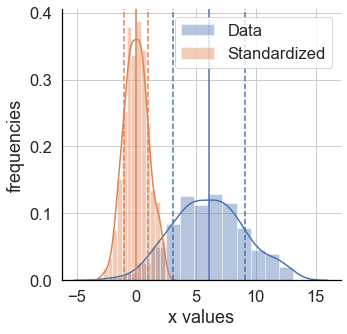

In [4]:
def zscore_plot(x):
    sns.distplot(x, label='Data')
    mean = np.mean(x)
    std = np.std(x)
    x_zscore = (x - mean)/(std)
    zscored_mean = np.mean(x_zscore)
    zscored_std = np.std(x_zscore)
    sns.distplot(x_zscore, label='Standardized')
    plt.xlabel('x values')
    plt.ylabel('frequencies')
    plt.axvline(mean, color='C0', linestyle='-')
    plt.axvline(mean + std, color='C0', linestyle='--')
    plt.axvline(mean - std, color='C0', linestyle='--')
    plt.axvline(zscored_mean, color='C1', linestyle='-')
    plt.axvline(zscored_mean+zscored_std, color='C1', linestyle='--')
    plt.axvline(zscored_mean-zscored_std, color='C1', linestyle='--')
    plt.legend(loc='best')
    plt.show()
    
x = np.random.normal(6, 3, 300)
zscore_plot(x)

Define necessary functions.

In [5]:
def polynomial_feature_example(x, y, regularization = None, reg_lambda=1, degrees=6):
    """
    Perform regularization on a polynomial feature set. 
    """
    poly_transform = PolynomialFeatures(degree=degrees, include_bias = False)
    x_poly = poly_transform.fit_transform(x.reshape(-1,1))
    
    #Regularization techniques need to be scaled in order to work properly
    x_scaler = StandardScaler().fit(x_poly)
    y_scaler = StandardScaler().fit(y.reshape(-1,1))
    x_poly_z = x_scaler.transform(x_poly)
    y_z = y_scaler.transform(y.reshape(-1,1))
    
    #Code to perform the model fitting and parameter estimation
    if regularization is None:
        #Least Squares problem
        plt.suptitle('Linear Regression', fontsize=20, fontweight='bold')
        lm_poly = linear_model.LinearRegression(fit_intercept=True)
        lm_poly.fit(x_poly_z,y_z)
        
    elif regularization is 'L1':
        #LASSO problem
        plt.suptitle('LASSO', fontsize=20, fontweight='bold')       
        lm_poly = linear_model.Lasso(alpha = reg_lambda, max_iter=1e8, fit_intercept=True)
        lm_poly.fit(x_poly_z,y_z)    
        
    elif regularization is 'L2':
        #ridge problem
        plt.suptitle('Ridge', fontsize=20, fontweight='bold')
        lm_poly = linear_model.Ridge(alpha = reg_lambda, max_iter=1e5, fit_intercept=True)
        lm_poly.fit(x_poly_z,y_z)
        
    x_model = np.linspace(min(x), max(x), 150).reshape(-1,1)
    x_model_transform = poly_transform.fit_transform(x_model)
    x_model_transform_z = x_scaler.transform(x_model_transform)
    
    
    y_model = lm_poly.predict(x_model_transform_z)*y_scaler.scale_ + y_scaler.mean_
    
    #********************************************************************************
    # Coefficients from scaled model can be transformed back into original units
    # This code is outside the scope of this class and can be ignored. 
    
    unscaled_coefficients = (lm_poly.coef_ * y_scaler.scale_ / x_scaler.scale_).flatten()
    
    poly_terms = [r'$({0:.3f})x ^ {{{1}}}$'.format(coef, i+1) for i, coef in enumerate(unscaled_coefficients)
                 if coef != 0]
    
    unscaled_intercept = lm_poly.intercept_*y_scaler.scale_ + y_scaler.mean_ \
                            - sum(unscaled_coefficients*x_scaler.mean_)
        
    intercept_str = r'${0:.1f} + $'.format(unscaled_intercept[0])
    title =  intercept_str + r'$+$'.join(poly_terms)
    #********************************************************************************
    
    plot_model(x_data, y_data, x_model, y_model, title=title)

### 2. Plot the *in silico* data and the true model. 

TypeError: 'int' object is not iterable

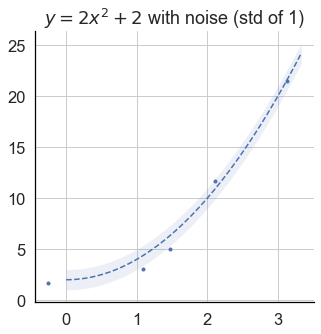

In [6]:
x_data, y_data = generate_noisy_data(quadratic, 1, n=5)

### 3. Add polynomial degrees, and run an MLR.. 

In [ ]:
polynomial_feature_example(x_data, y_data, degrees=6)

### 4. Calculate the LASSO regression coefficients for the *in silico* data generated above. 

In [ ]:
polynomial_feature_example(x_data, y_data, regularization='L1', reg_lambda=0.01)

### 5. Calculate the Ridge regression coefficients for the *in silico* data generated above. 

In [ ]:
polynomial_feature_example(x_data, y_data, regularization='L2', reg_lambda = 0.01)

### 6. Significantly increase the number of observations, *n*, and re-calculate the regression coefficients. 
When the number of samples, *n*, is high, we do not impose the risk of overfitting as it is unlikely we would propose a model with *n*-degrees of freedom when *n>>0*. 


In [ ]:
x_data, y_data = generate_noisy_data(quadratic, 1, n=300)
polynomial_feature_example(x_data, y_data)
polynomial_feature_example(x_data, y_data, regularization='L1', reg_lambda = .1)
polynomial_feature_example(x_data, y_data, regularization='L2', reg_lambda = .1)

### How do we determine an appropriate $\lambda$?

Here is where cross validation comes in. Let's do it with elastic net. Remember that we have a different cost function, with two $\lambda$ parameters. $\lambda_R$ describes the regularization penalty on the $L^2$ norm, and $\lambda_L$ describes the penalty on $L^1$ norm.

In order to work with the Elastic Net software in python, we are going to need to define these in terms of two other parameters. 

$$ \lambda_L =  \alpha * (L_1\text{ratio}) $$
$$ \lambda_R =  \alpha * (1 - L_1\text{ratio}) $$

Where $$ L_1\text{ratio} = \frac{\lambda_L}{\lambda_L + \lambda_R}$$ 

We are going to go with a 80%/20% train/test split. 

In [7]:
def cross_validation(model, X, y, k=5):
    scores = cross_validate(model, X, y, cv=k,
                            scoring=('r2', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    
    temp_model = model.fit(X, y)
    non_zero = np.count_nonzero(temp_model.coef_)
    return np.mean(scores['train_r2']),np.mean(scores['test_r2']), non_zero

def model_selection(X,y,test=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
    X_z = X_scaler.transform(X_train)
    y_z = y_scaler.transform(y_train.reshape(-1,1))
    
    alpha_dict = {}
    p_dict = {}
    i = 0
    lim = 64
    for alpha in [0, 1e-5, 1e-3, 1e-2, 1e-1, 0.5, 1, 5]:
        alpha_dict[str(alpha)] = {}
        p_dict[str(alpha)] = {}
        for ratio in [0, .1, .5, .7, .9, .95, .99, 1]:
            i += 1
            print(f"{i} of {lim}")
            model = linear_model.ElasticNet(alpha=alpha, l1_ratio=ratio) 

            train_r2, test_r2, non_zero = cross_validation(model, X_z, y_z)
            alpha_dict[str(alpha)][str(ratio)] = f"{train_r2:.4f}/{test_r2:.4f}"
            p_dict[str(alpha)][str(ratio)] = non_zero
            
    cv_df = pd.DataFrame(alpha_dict)
    parameter_df = pd.DataFrame(p_dict)
    cv_df.index.name = "L1 Ratio"
    cv_df.style.set_caption("Alpha")
    parameter_df.index.name = "L1 Ratio"
    parameter_df.style.set_caption("Alpha")    
    return cv_df, parameter_df, X_train, X_test, y_train, y_test


x_reg, y_reg = make_regression(n_samples=100, n_features=100, 
                               n_informative=5, 
                               n_targets=1, bias=0.2,  
                               noise=6, random_state=504)

print("Columns = alpha")
print("Rows = L1_ratio")
cv_df, parameter_df, X_train, X_test, y_train, y_test = model_selection(x_reg, y_reg)
print("R^2 from TRAIN/VALIDATION:")
cv_df

Columns = alpha
Rows = L1_ratio
1 of 64.
2 of 64.
3 of 64.
4 of 64.
5 of 64.
6 of 64.
7 of 64.
8 of 64.
9 of 64.
10 of 64.
11 of 64.
12 of 64.
13 of 64.
14 of 64.
15 of 64.
16 of 64.
17 of 64.
18 of 64.
19 of 64.
20 of 64.
21 of 64.
22 of 64.
23 of 64.
24 of 64.
25 of 64.
26 of 64.
27 of 64.
28 of 64.
29 of 64.
30 of 64.
31 of 64.
32 of 64.
33 of 64.
34 of 64.
35 of 64.
36 of 64.
37 of 64.
38 of 64.
39 of 64.
40 of 64.
41 of 64.
42 of 64.
43 of 64.
44 of 64.
45 of 64.
46 of 64.
47 of 64.
48 of 64.
49 of 64.
50 of 64.
51 of 64.
52 of 64.
53 of 64.
54 of 64.
55 of 64.
56 of 64.
57 of 64.
58 of 64.
59 of 64.
60 of 64.
61 of 64.
62 of 64.
63 of 64.
64 of 64.
R^2 from TRAIN/VALIDATION:


,0,1e-05,0.001,0.01,0.1,0.5,1,5
L1 Ratio,,,,,,,,
0,1.0000/0.1428,1.0000/0.1433,1.0000/0.5488,0.9999/0.5629,0.9933/0.5718,0.9395/0.5037,0.8682/0.4290,0.5199/0.1921
0.1,1.0000/0.1428,1.0000/0.1440,1.0000/0.9301,0.9997/0.9411,0.9879/0.8845,0.8704/0.7140,0.6915/0.5558,0.0470/0.0189
0.5,1.0000/0.1428,1.0000/0.1469,1.0000/0.9907,0.9986/0.9934,0.9763/0.9706,0.6708/0.6407,0.1629/0.1374,0.0000/-0.0295
0.7,1.0000/0.1428,1.0000/0.1485,0.9999/0.9918,0.9981/0.9943,0.9711/0.9666,0.5200/0.4877,0.0037/-0.0253,0.0000/-0.0295
0.9,1.0000/0.1428,1.0000/0.1501,0.9999/0.9921,0.9977/0.9946,0.9651/0.9612,0.3393/0.3138,0.0000/-0.0295,0.0000/-0.0295
0.95,1.0000/0.1428,1.0000/0.1505,0.9999/0.9922,0.9976/0.9946,0.9634/0.9597,0.2876/0.2623,0.0000/-0.0295,0.0000/-0.0295
0.99,1.0000/0.1428,1.0000/0.1509,0.9998/0.9922,0.9975/0.9947,0.9620/0.9584,0.2459/0.2212,0.0000/-0.0295,0.0000/-0.0295
1,1.0000/0.1428,1.0000/0.1510,0.9998/0.9922,0.9975/0.9947,0.9617/0.9581,0.2352/0.2107,0.0000/-0.0295,0.0000/-0.0295


In [8]:
print("Number of parameters in each model:")
parameter_df

Number of parameters in each model:


,0,1e-05,0.001,0.01,0.1,0.5,1,5
L1 Ratio,,,,,,,,
0,100,100,100,100,100,100,100,100
0.1,100,100,85,68,50,27,17,3
0.5,100,100,77,32,3,3,3,0
0.7,100,100,68,21,3,3,0,0
0.9,100,100,65,16,3,3,0,0
0.95,100,100,63,16,3,3,0,0
0.99,100,100,63,14,3,3,0,0
1,100,100,63,14,3,3,0,0


In [ ]:
def parity_plot(true, pred, r_squared=None, title='', alpha=None, color=None, hue=None):
    """
    plot true vs the predicted data
    inputs: 2 list-like (arrays) data structures
    """
    fig, ax = plt.subplots(1,1,figsize=(10, 8))
    if hue is not None:
        sns.scatterplot(x=true, y=pred, hue=hue)
    else: 
        if color is None: sns.scatterplot(x=true, y=pred)
        else: sns.scatterplot(x=true, y=pred, alpha=alpha, color=color)
    min_value = min(min(true), min(pred))
    max_value = max(max(true), max(pred))
    plt.plot([min_value, max_value],[min_value, max_value], '--', label="parity")
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    sns.despine()
    plt.text(1.01, 0.98, r"$R^2 = {0:.2f}$".format(r_squared),
         ha='left', va='top', size =LABEL_FONT,
         transform=ax.transAxes)
    plt.title('Parity Plot: {}'.format(title), size=TITLE_FONT)
    plt.legend(loc='best')
    plt.show()    

def test_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    parity_plot(y_train, y_train_pred.flatten(), r_squared =model.score(X_train, y_train), title="Training Data", color="grey", alpha=0.5)
    parity_plot(y_test, y_test_pred.flatten(), r_squared =model.score(X_test, y_test), title="Test Data", color="blue", alpha=1)

@widgets.interact_manual(alpha=[0, 1e-5, 1e-3, 1e-1, 0.5, 1, 5], l1_ratio=[0, .1, .5, .7, .9, .95, .99, 1])
def build_and_test(alpha, l1_ratio):
    model = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio) 
    test_model(model, X_train, X_test, y_train, y_test)
